# Detección de fraudes

In [1]:
# Importamos las librerías necesarias
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,plot_confusion_matrix,roc_auc_score, classification_report, confusion_matrix, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

### Descripción del dataset

Una plataforma de ventas online nos contrata para que realicemos un modelo que nos
permita detectar un posible fraude dada cierta operación para ello contamos con un dataset
que contiene las siguientes columnas:

- Step: representa una unidad de tiempo donde 1 step equivale a 1 hora
- type: tipo de transacción en línea
- amount: el importe de la transacción
- nameOrig: cliente que inicia la transacción
- oldbalanceOrg: saldo antes de la transacción
- newbalanceOrig: saldo después de la transacción
- nameDest: destinatario de la transacción
- oldbalanceDest: saldo inicial del destinatario antes de la transacción
- newbalanceDest: el nuevo saldo del destinatario después de la transacción
- isFraud: transacción fraudulenta

In [2]:
# Leemos el dataset
df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

In [3]:
# Visualizamos los primeros 5 registros
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Visualizamos la forma del dataset
df.shape

(6362620, 11)

In [5]:
# Obtenemos los estadísticos más importantes del dataset
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [6]:
# Obtenemos la cantidad de datos nulos por variable
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

<AxesSubplot:ylabel='isFraud'>

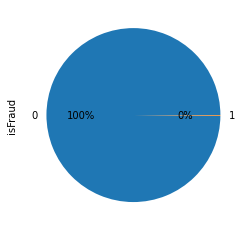

In [7]:
# Distribución de la variable de salida
df.isFraud.value_counts().plot.pie(autopct='%1.0f%%', figsize=(4,4))

In [8]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

### Preparación del dataset

In [9]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [10]:
columns = {
    'step': 'step',
    'type': 'type',
    'amount': 'amount',
    'nameOrig': 'name_orig',
    'oldbalanceOrg': 'old_balance_org',
    'newbalanceOrig': 'new_balance_orig',
    'nameDest': 'name_dest',
    'oldbalanceDest': 'old_balance_dest',
    'newbalanceDest': 'new_balance_dest',
    'isFraud': 'is_fraud',
    'isFlaggedFraud': 'is_flagged_fraud',
}

In [11]:
df.rename(columns=columns, inplace=True)

### Variables categóricas:
- type

### Variables numéricas:
- step
- amount
- old_balance_org
- new_balance_orig
- old_balance_dest
- new_balance_dest

### Variables a descartar: 
- name_orig
- name_dest
- is_flagged_fraud

> Las variables **name_orig** y **name_dest** se descartan ya que son categóricas, pero la cantidad de categorías que contienen es muy alta, por lo que transformarlas en variables dummy (One Hot Encoder), haría que el dataset tenga muchas dimensiones y suframos de "la maldición de la dimensionalidad" (Curse of dimensionality). La variable **is_flagged_fraud** no aporta información relevante para el análisis.

In [12]:
df.drop(columns=['name_orig', 'name_dest', 'is_flagged_fraud'], inplace=True)

### Pre-procesamiento

In [13]:
# División de las variables predictoras y la variable a predecir
X = df[['type', 'step', 'amount', 'old_balance_org', 'new_balance_orig', 'old_balance_dest', 'new_balance_dest']]
y = df[['is_fraud']]

In [14]:
X.dtypes

type                 object
step                  int64
amount              float64
old_balance_org     float64
new_balance_orig    float64
old_balance_dest    float64
new_balance_dest    float64
dtype: object

#### Transformación de datos y pipeline de entrenamiento

In [15]:
numeric_features = ['step', 'amount', 'old_balance_org', 'new_balance_orig', 'old_balance_dest', 'new_balance_dest']
categorical_features = ['type']

In [16]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

In [17]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

In [19]:
model = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegressionCV(scoring='f1'))])

In [20]:
model_balanced = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegressionCV(class_weight = 'balanced'))])

### Dataset desbalanceado

Al tratarse de un dataset con un desbalance de clases evidente, se proponen las siguientes estrategias para intentar mitigar el problema:
- Undersampling
- Oversampling
- Class weight

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [22]:
# chequeamos la presencia relativa de cada clase y el tamaño de los datasets
print('Entrenamiento:',X_train.shape)
print('Testeo:',X_test.shape)
print('\nClases train:')
print(y_train.value_counts(normalize=True))
print('\nClases test:')
print(y_test.value_counts(normalize=True))

Entrenamiento: (5090096, 7)
Testeo: (1272524, 7)

Clases train:
is_fraud
0           0.998709
1           0.001291
dtype: float64

Clases test:
is_fraud
0           0.998709
1           0.001291
dtype: float64


#### Definición del reporte de métricas

In [23]:
def metric_report(y_test, y_pred, y_proba):  
    print(classification_report(y_test,y_pred))
    
    print('Area bajo la curva ROC:',np.round(roc_auc_score(y_test,y_proba[:,1]),4))
    
    precision, recall,threshold=precision_recall_curve(y_test,y_proba[:,1]);

    print('Area bajo la curva Precision-Recall:',np.round(auc(recall,precision),4))

### Undersampling

In [24]:
from imblearn.under_sampling import RandomUnderSampler

undersampler=RandomUnderSampler(sampling_strategy='majority');

X_train_us ,y_train_us=undersampler.fit_resample(X_train, y_train);

print('Composición del training set:')
print(y_train_us.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
is_fraud
0           6570
1           6570
dtype: int64

Composición del test set:
is_fraud
0           1270881
1              1643
dtype: int64


In [25]:
model.fit(X_train_us, y_train_us)

c:\users\lucas\documents\especialización en inteligencia artificial de la uba\5. aprendizade de máquina 1\tp_1\aprendizaje_de_maquina_i_ceia_tp_i\venv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\lucas\documents\especialización en inteligencia artificial de la uba\5. aprendizade de máquina 1\tp_1\aprendizaje_de_maquina_i_ceia_tp_i\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'old_balance_org',
                                                   'new_balance_orig',
                                                   'old_balance_dest',
                                                   'new_balance_dest']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type'])])),
                ('classifier', LogisticRegressionCV(scoring='f1'))])

In [26]:
y_pred = model.predict(X_test)

In [27]:
y_proba = model.predict_proba(X_test)

In [28]:
metric_report(y_test, y_pred, y_proba)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270881
           1       0.02      0.96      0.05      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.95      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524

Area bajo la curva ROC: 0.9908
Area bajo la curva Precision-Recall: 0.5749


### Oversampling

In [29]:
from imblearn.over_sampling import RandomOverSampler

oversampler=RandomOverSampler(sampling_strategy='minority');

X_train_os,y_train_os=oversampler.fit_resample(X_train, y_train);

print('Composición del training set:')
print(y_train_os.value_counts())

print('\nComposición del test set:')
print(y_test.value_counts())

Composición del training set:
is_fraud
0           5083526
1           5083526
dtype: int64

Composición del test set:
is_fraud
0           1270881
1              1643
dtype: int64


In [30]:
model.fit(X_train_os, y_train_os)

c:\users\lucas\documents\especialización en inteligencia artificial de la uba\5. aprendizade de máquina 1\tp_1\aprendizaje_de_maquina_i_ceia_tp_i\venv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\lucas\documents\especialización en inteligencia artificial de la uba\5. aprendizade de máquina 1\tp_1\aprendizaje_de_maquina_i_ceia_tp_i\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'old_balance_org',
                                                   'new_balance_orig',
                                                   'old_balance_dest',
                                                   'new_balance_dest']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type'])])),
                ('classifier', LogisticRegressionCV(scoring='f1'))])

In [31]:
y_pred = model.predict(X_test)

In [32]:
y_proba = model.predict_proba(X_test)

In [33]:
metric_report(y_test, y_pred, y_proba)

              precision    recall  f1-score   support

           0       1.00      0.95      0.97   1270881
           1       0.02      0.96      0.05      1643

    accuracy                           0.95   1272524
   macro avg       0.51      0.96      0.51   1272524
weighted avg       1.00      0.95      0.97   1272524

Area bajo la curva ROC: 0.9909
Area bajo la curva Precision-Recall: 0.5821


### Class weighting

In [34]:
model_balanced.fit(X_train, y_train)

c:\users\lucas\documents\especialización en inteligencia artificial de la uba\5. aprendizade de máquina 1\tp_1\aprendizaje_de_maquina_i_ceia_tp_i\venv\lib\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\users\lucas\documents\especialización en inteligencia artificial de la uba\5. aprendizade de máquina 1\tp_1\aprendizaje_de_maquina_i_ceia_tp_i\venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['step', 'amount',
                                                   'old_balance_org',
                                                   'new_balance_orig',
                                                   'old_balance_dest',
                                                   'new_balance_dest']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['type'])])),
                ('classifier', LogisticRegressionCV(class_weight='balanced'))])

In [35]:
y_pred = model.predict(X_test)

In [36]:
y_proba = model.predict_proba(X_test)

In [37]:
metric_report(y_test, y_pred, y_proba)

              precision    recall  f1-score   support

           0       1.00      0.54      0.71   1270881
           1       0.00      1.00      0.01      1643

    accuracy                           0.55   1272524
   macro avg       0.50      0.77      0.36   1272524
weighted avg       1.00      0.55      0.70   1272524

Area bajo la curva ROC: 0.953
Area bajo la curva Precision-Recall: 0.1347


### Resultados obtenidos

|     Metric/Model     |    Undersampling   |    Oversampling    |   Class weighting  |
|:--------------------:|:------------------:|:------------------:|:------------------:|
| precision            | 0: 1.00 \| 1: 0.02 | 0: 1.00 \| 1: 0.02 | 0: 1.00 \| 1: 0.00 |
| recall               | 0: 0.95 \| 1: 0.96 | 0: 0.95 \| 1: 0.96 | 0: 0.54 \| 1: 1.00 |
| f1-score             | 0: 0.97 \| 1: 0.05 | 0: 0.97 \| 1: 0.05 | 0: 0.71 \| 1: 0.01 |
| accuracy             |        0.95        | 0.95               | 0.55               |
| AUCROC               |       0.9908       |     **0.9909**     | 0.953              |
| AUC Precision-Recall |       0.5749       |     **0.5821**     | 0.1347             |

### Conclusión

> En el presente notebook, se realiza un análisis exploratorio de los datos básico con el objetivo de comprender el problema planteado. Además, se propone un flujo de pre-procesamiento de los datos. Finalmente, se entrena un modelo simple (regresión logística), empleando tres estrategias para mitigar el desbalance de los datos: undersampling, oversampling y class-weighting. El objetivo de entrenar este modelo simple con estas estrategias, es poder establecer un baseline contra el que comparar modelos más complejos.

> De estos experimentos, podemos concluir que la mejor estrategia para afrontar el dataset desbalanceado es la de **oversampling, y que el modelo se comporta muy bien para predecir la clase mayoritaria (0), no obstante presenta graves problemas para predecir la clase minioritaria (1)**.

> El próximo paso a seguir es entrenar modelos más complejos de los vistos en clases (como árboles de decisión, random forest, Linear SVM y SVM), empleando la técnica de oversampling, para intentar obtener mejores resultados.